In [1]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
import analysis as ana
import numpy as np 
import importlib

import tensorflow as tf 
tfk = tf.keras
tfkl = tfk.layers

In [2]:
COMMON_PATH = "../data/COMMON_images_masks/common_"
GROUP_PATH = "../data/g3_"
grp_indices = [59, 60, 61]
cmn_indices = [40, 41, 42]

# Data Preparation
## Manual Annotation

In [10]:
importlib.reload(ana)
data = ana.PelvicData()

In [4]:
i=84

84


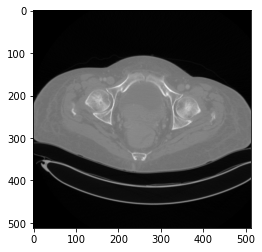

In [5]:
plt.imshow(data.grp_img[60][i], cmap="gray")
print(i)
i+=1

In [6]:
print(f"train X shape:{data.train_X.shape}, train y shape:{data.train_y.shape} ")

train X shape:(858, 512, 512), train y shape:(858,) 


## Data preprocessing:
We need to tranform the images from gray scale to RGB in order to be able to use ResNet

In [7]:
%%time
importlib.reload(ana)
data = ana.PelvicData()
data.train_X.shape
data.train_X_3C.shape

Wall time: 14.6 s


(858, 512, 512, 3)

In [8]:
np.save("../data/train_X.npy", data.train_X)
np.save("../data/train_X_3C.npy", data.train_X_3C)
np.save("../data/train_y.npy", data.train_y)

## Inception V3 

In [19]:
%%time
importlib.reload(ana)
data = ana.PelvicData()

Wall time: 14.5 s


In [11]:
inception_model = tfk.applications.InceptionV3(weights="imagenet", include_top=False, pooling="max")

87916544/87910968 [==============================] - 8s 0us/step


In [12]:
input = tfkl.Input([None, None, 3], dtype = tf.int16)
x = tf.cast(input, tf.float32)
x = tfk.applications.inception_v3.preprocess_input(x)
inception_model = tfk.applications.InceptionV3(weights="imagenet", include_top=False, pooling="max")
inception_output = inception_model(x)
hidden_layer = tfkl.Dense(512, activation='relu')(inception_output)
hl_reg = tfkl.Dropout(0.8)(hidden_layer)
output_layer = tf.keras.layers.Dense(1, activation='softmax')(hl_reg)
model = tf.keras.models.Model(inputs=input, outputs=output_layer)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, None, None, 3)     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, None, None, 3)     0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, None, None, 3)     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

### Training 

In [14]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
inception_model.trainable = False
for layer in inception_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-3)
model.compile(optimizer=optimizer, loss='binary_crossentropy', 
              metrics=['acc'])

In [20]:
history = model.fit(x=data.train_X_3C, y=data.train_y, epochs=10, batch_size=32, validation_split= 0.1)

ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found following types in the input: [<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>]